# Introduction

In [1]:
%matplotlib inline
from collections import OrderedDict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from data import CodesInDbs, Mappings, Databases
import normalize
mpl.rc("savefig", dpi=130)

In [2]:
PROJECT = 'safeguard'
import pathlib

with open('../projects/{}/variations.yaml'.format(PROJECT)) as f:
    variations = yaml.load(f)

with open('../projects/{}/config.yaml'.format(PROJECT)) as f:
    config = yaml.load(f)
    databases = Databases.of_config(config)
    coding_systems = config['coding-systems']

with open('../projects/{}/events.yaml'.format(PROJECT)) as f:
    events = yaml.load(f)
    event_names = {}
    for event in events:
        casedef = yaml.load(open('../projects/{}/case-definitions/{}.yaml'.format(PROJECT, event)))
        event_names[event] = casedef['name']

with open('../projects/{}/mappings.yaml'.format(PROJECT)) as f:
    mappings = Mappings.of_raw_data(yaml.load(f))
    mappings = normalize.mappings(mappings, databases)

with open('../codes-in-dbs.json') as f:
    codes_in_dbs = CodesInDbs.of_data(json.load(f))
    
def database_label(database):
    return "{} ({})".format(database, databases.coding_system(database))
    
df0 = pd.read_csv('../{}.evaluations.csv'.format(PROJECT))
df = df0['variation event database recall precision'.split()]
df.head()

,variation,event,database,recall,precision
0,1-PAR-CHD.expand,hs,GePaRD,0.041667,0.333333
1,1-PAR-CHD.expand,hs,CPRD,0.416667,0.789474
2,1-PAR-CHD.expand,hs,IPCI,0.333333,1.000000
3,1-PAR-CHD.expand,hs,Medicare,0.800000,0.800000
4,1-PAR-CHD.expand,mi,GePaRD,0.428571,0.750000


# Baseline

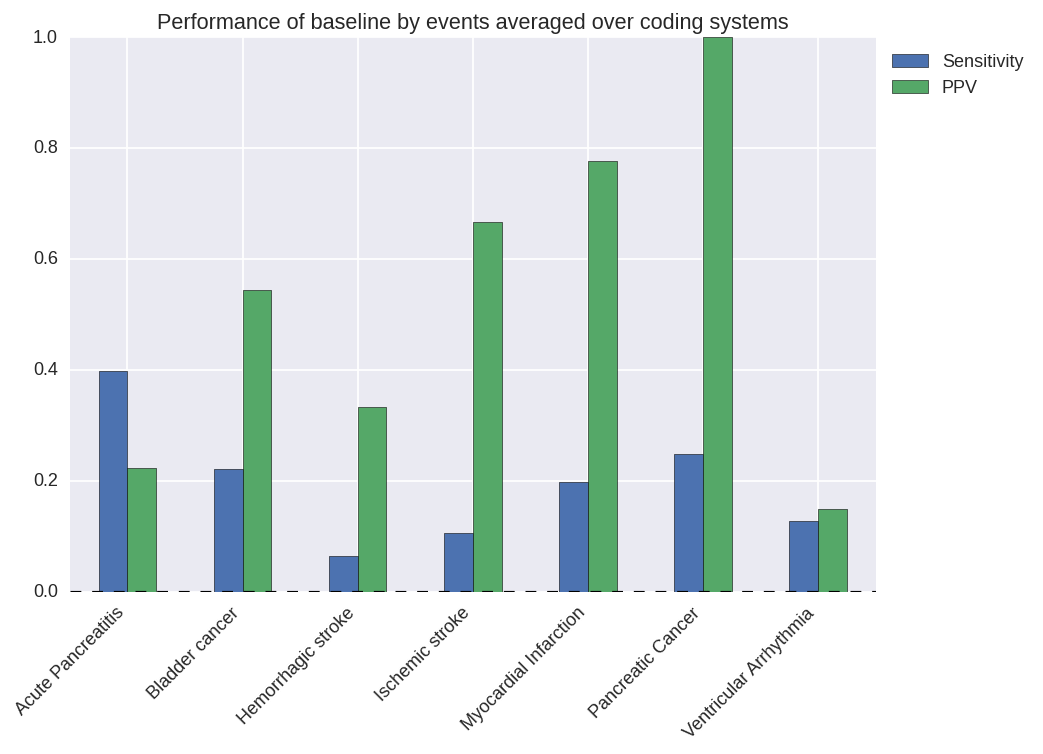

In [3]:
title = 'Performance of baseline by events averaged over coding systems'
averages_compare = pd.DataFrame([
    df[df.variation == 'baseline'].groupby('event').recall.mean(),
    df[df.variation == 'baseline'].groupby('event').precision.mean(),
])
averages_compare.index = ['Sensitivity', 'PPV']
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

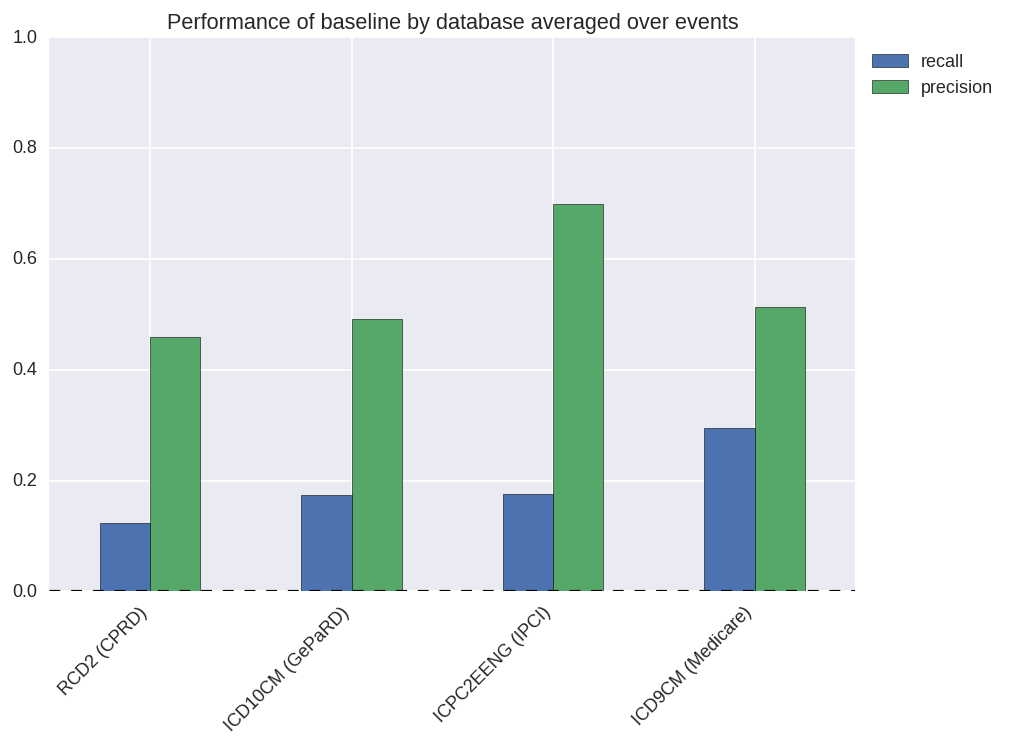

In [4]:
title = 'Performance of baseline by database averaged over events'
averages_compare = pd.DataFrame([
    df[df.variation == 'baseline'].groupby('database').recall.mean(),
    df[df.variation == 'baseline'].groupby('database').precision.mean(),
])
averages_compare.columns = averages_compare.columns.map(lambda db: '{} ({})'.format(coding_systems[db], db))
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

# Max-recall

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia
Sensitivity,1,0.980769,0.986111,0.939773,0.924603,0.983945,0.931481


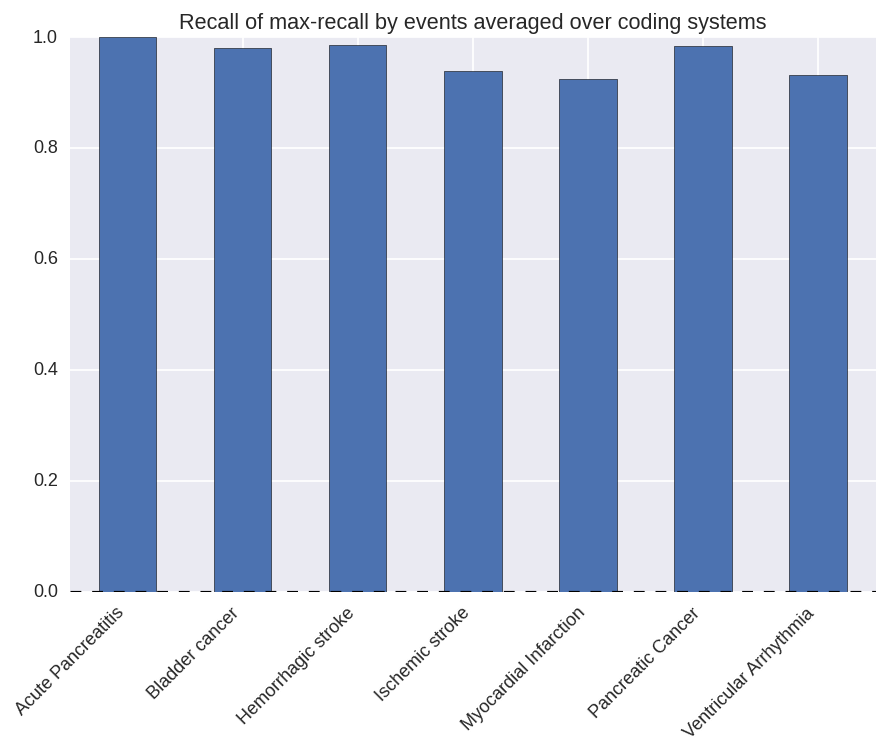

In [9]:
title = 'Recall of max-recall by events averaged over coding systems'
averages_compare = pd.DataFrame([
    df[df.variation == 'max-recall'].groupby('event').recall.mean(),
])
averages_compare.index = ['Sensitivity']
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.T.plot(kind='bar', title=title, legend=False, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
averages_compare

,CPRD (RCD2),GePaRD (ICD10CM),IPCI (ICPC2EENG),Medicare (ICD9CM)
Sensitivity,0.929871,0.938033,1,0.988095


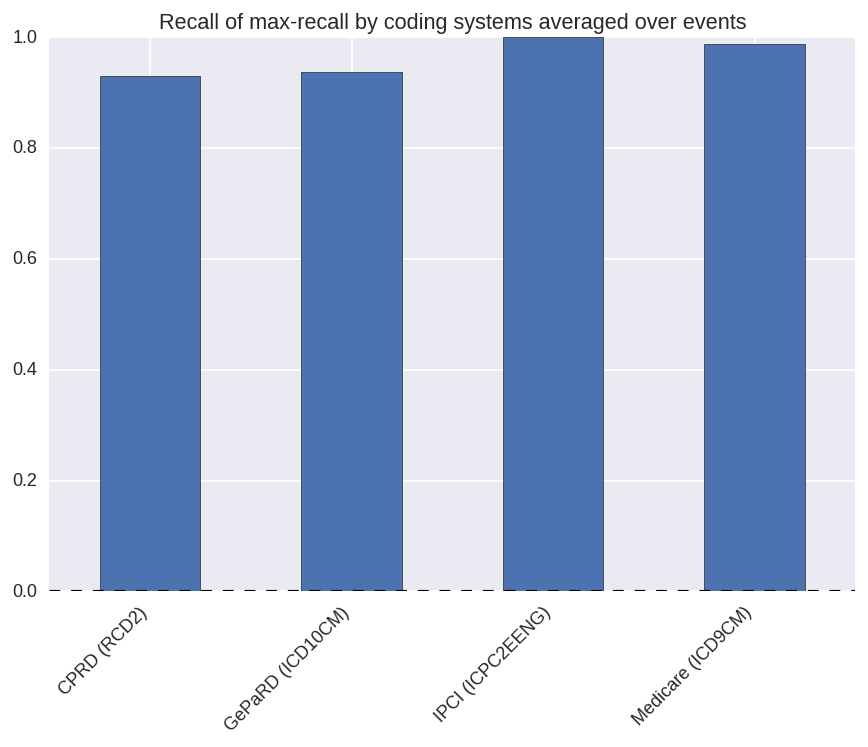

In [8]:
title = 'Recall of max-recall by coding systems averaged over events'
averages_compare = pd.DataFrame([
    df[df.variation == 'max-recall'].groupby('database').recall.mean(),
])
averages_compare.index = ['Sensitivity']
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.T.plot(kind='bar', title=title, legend=False, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
averages_compare

# Compare relations for expansion

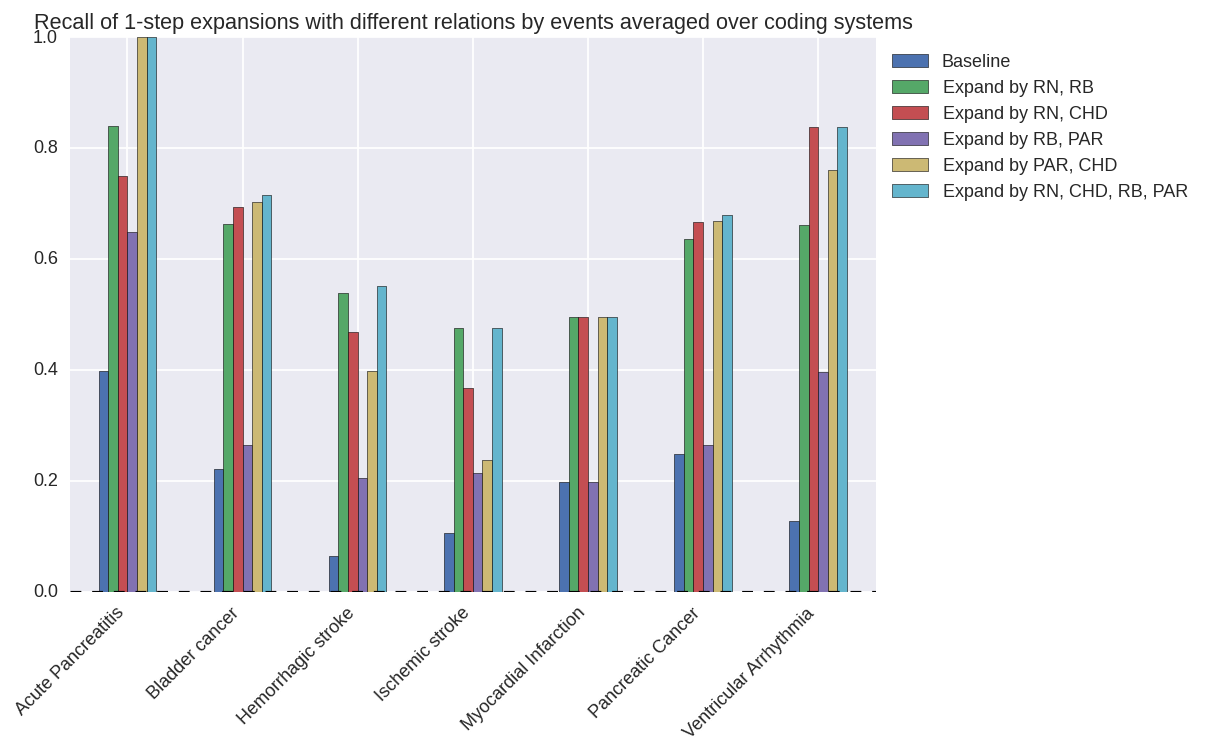

In [18]:
title = 'Recall of 1-step expansions with different relations by events averaged over coding systems'
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'Expand by RN, RB'),
    ('1-RN-CHD.expand', 'Expand by RN, CHD'),
    ('1-RB-PAR.expand', 'Expand by RB, PAR'),
    ('1-PAR-CHD.expand', 'Expand by PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'Expand by RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

# Increasing recall with more expansion steps

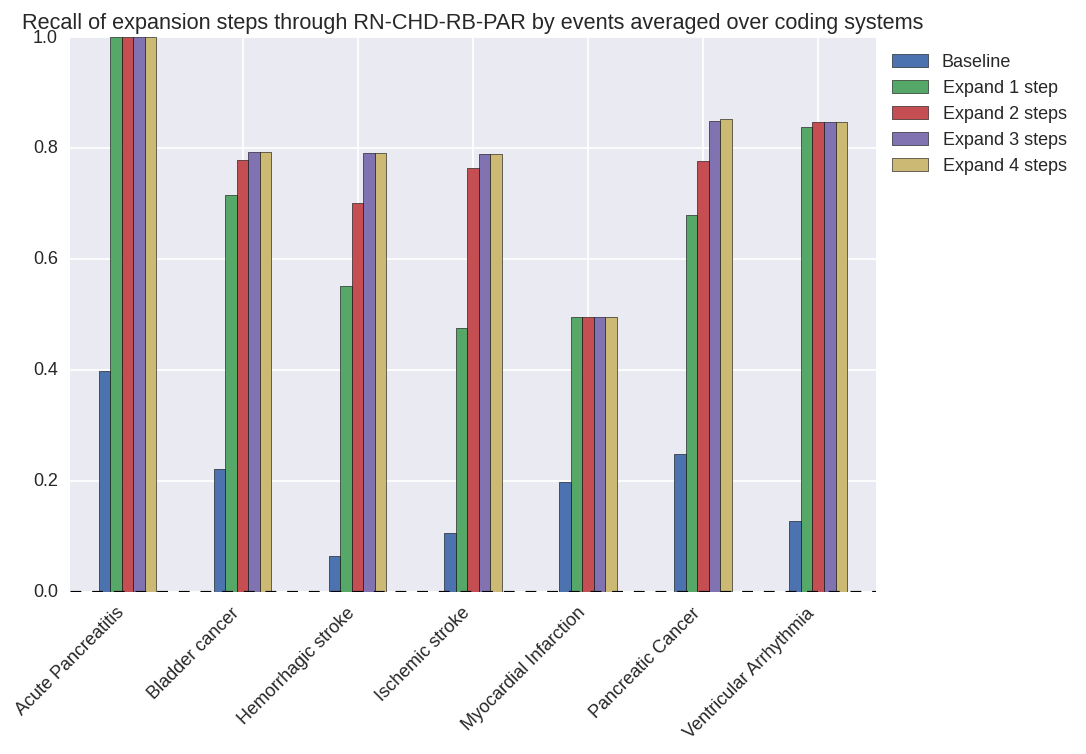

In [15]:
title = 'Recall of expansion steps through RN-CHD-RB-PAR by events averaged over coding systems'
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', 'Expand 1 step'),
    ('2-RN-CHD-RB-PAR.expand', 'Expand 2 steps'),
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('4-RN-CHD-RB-PAR.expand', 'Expand 4 steps'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

# Filtering codes by occurrences

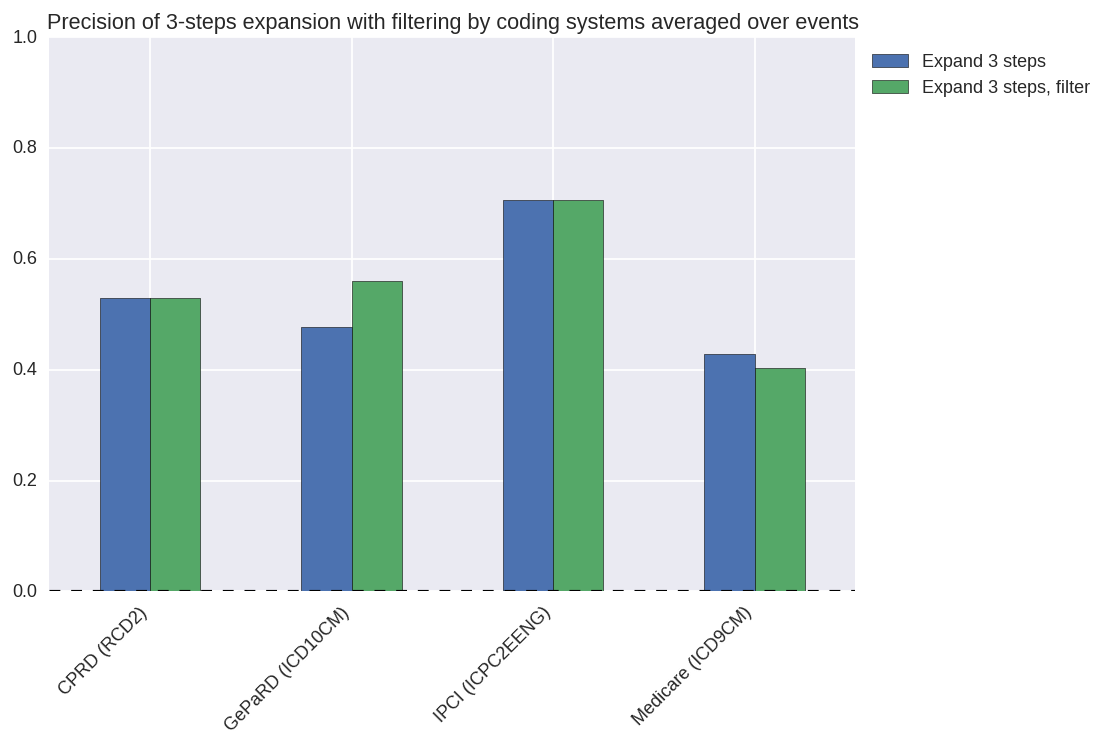

In [22]:
title = 'Precision of 3-steps expansion with filtering by coding systems averaged over events'
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
])
averages_compare.index = compare_variations.values()
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

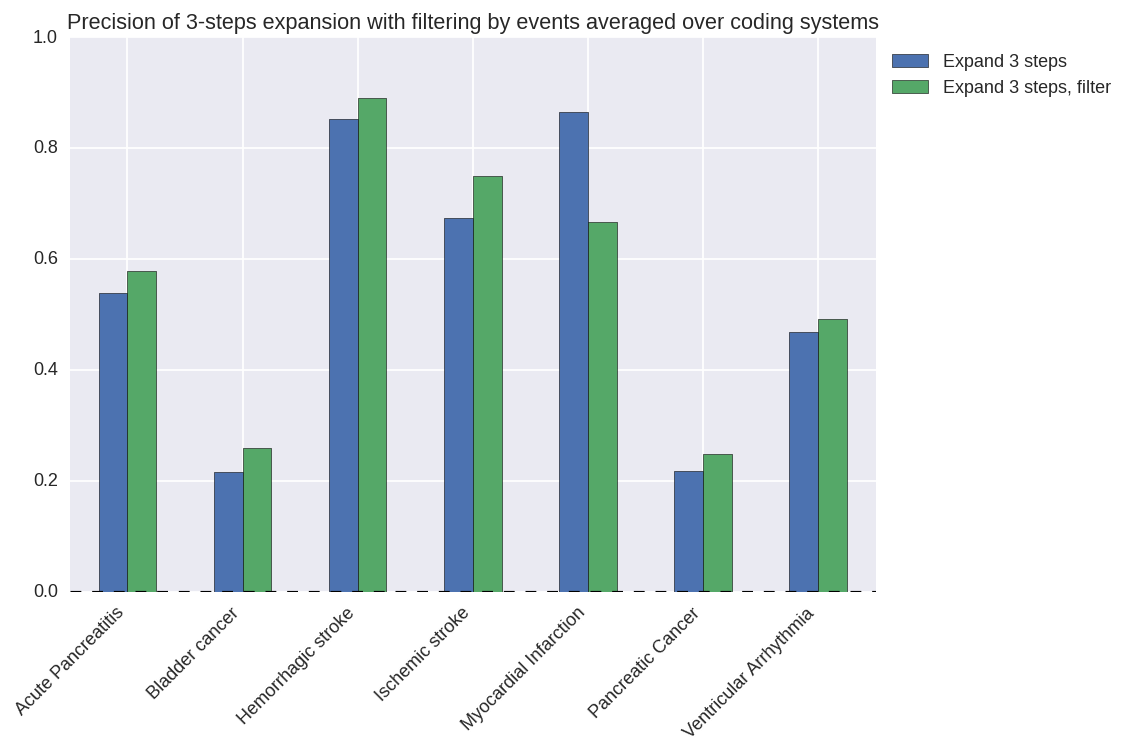

In [20]:
title = 'Precision of 3-steps expansion with filtering by events averaged over coding systems'
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
])
averages_compare.index = compare_variations.values()
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

# By databases

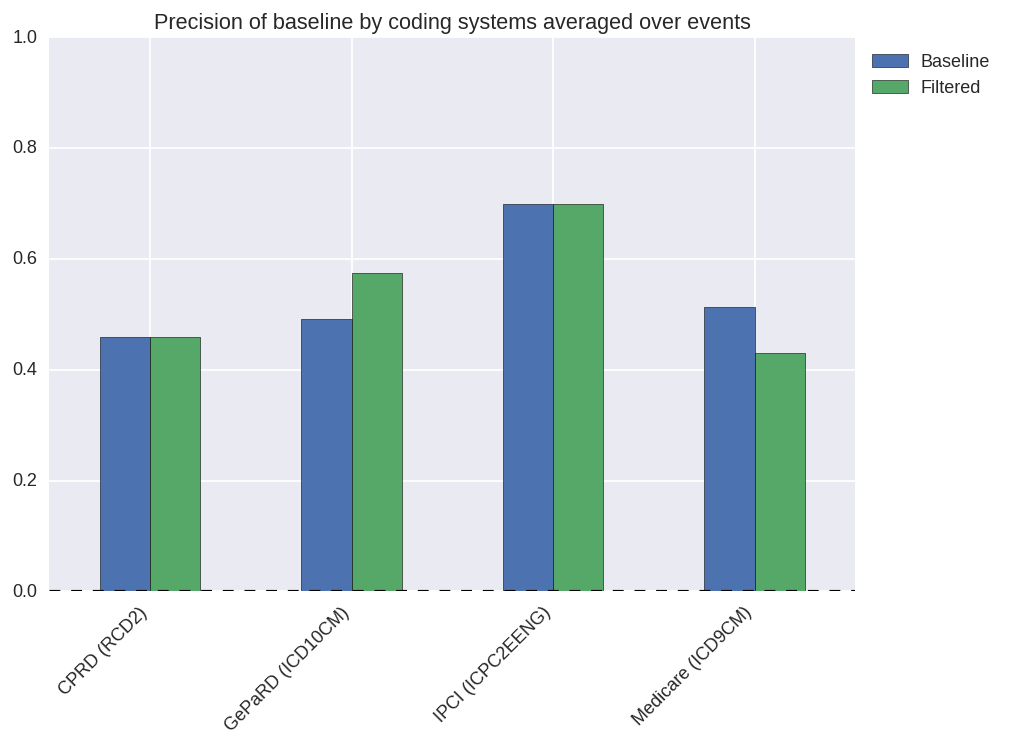

In [23]:
title = 'Precision of baseline by coding systems averaged over events'
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
])
averages_compare.index = compare_variations.values()
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.T.plot(kind='bar', title=title, ylim=(0, 1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

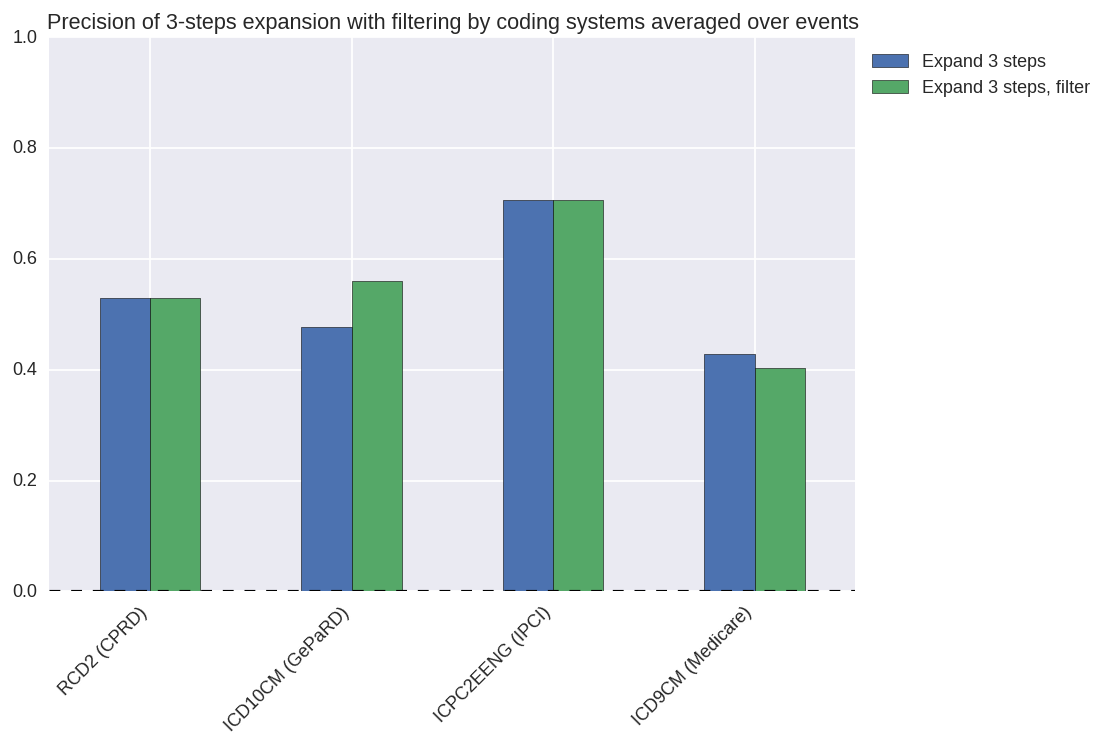

In [24]:
title = 'Precision of 3-steps expansion with filtering by coding systems averaged over events'
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
])
averages_compare.index = compare_variations.values()
averages_compare.columns = averages_compare.columns.map(lambda db: '{} ({})'.format(coding_systems[db], db))
averages_compare.T.plot(kind='bar', title=title, ylim=(0,1))
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
_=()

# Accordance of reference mappings to occurrence data

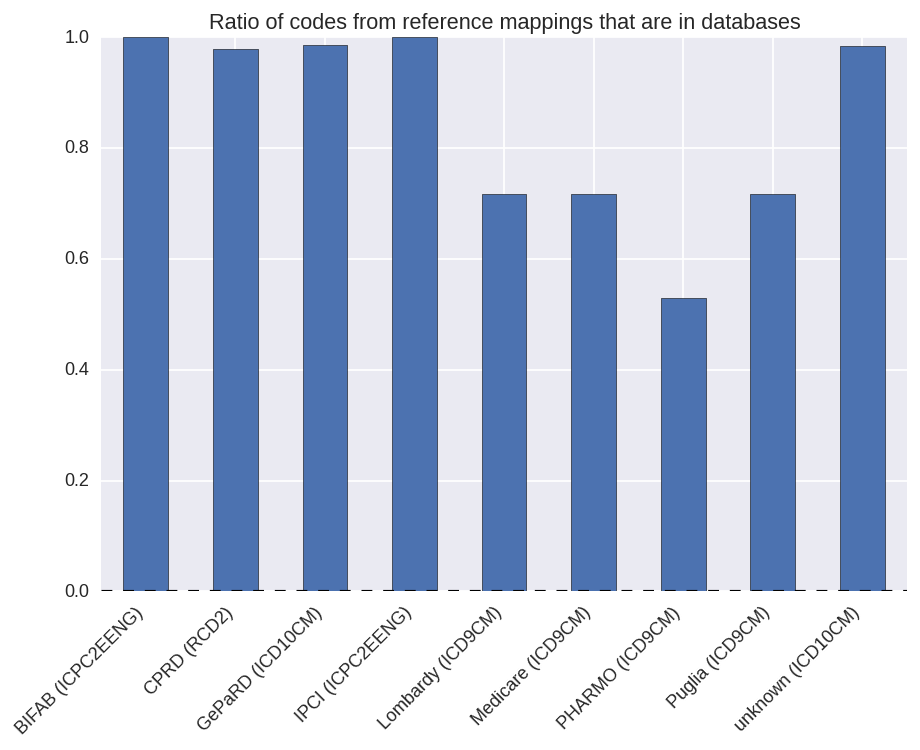

In [25]:
with open('../safeguard.reference-validity.json') as f:
    reference_validity = pd.Series(json.load(f))
title = 'Ratio of codes from reference mappings that are in databases'
reference_validity.plot(kind='bar', title=title, ylim=(0,1))
_=plt.xticks(rotation=45, ha='right')